In [179]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [180]:
#Directory paths
train_path = "/kaggle/input/standard-ocr-dataset/data/training_data"
test_path = "/kaggle/input/standard-ocr-dataset/data/testing_data"

In [181]:
#Transformers
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [182]:
#Loading data
train_data = datasets.ImageFolder(train_path,transform=train_transform)
test_data = datasets.ImageFolder(test_path,transform=train_transform)
train_data[0][0].shape

torch.Size([3, 128, 128])

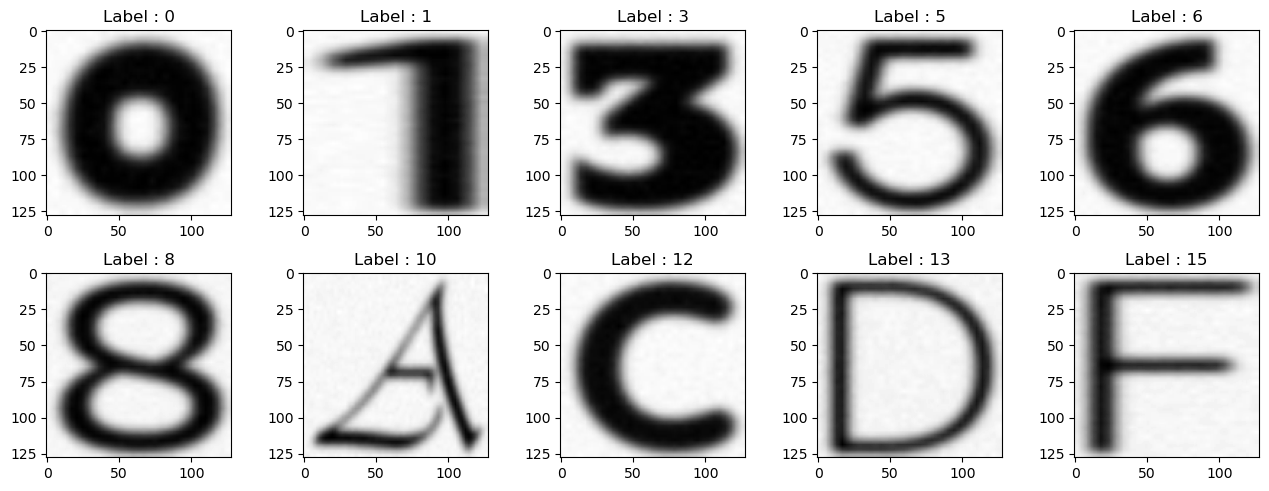

In [183]:
#Visualizing data
plt.figure(figsize=(13,5))
for i in range(10):
    image,label = train_data[i*1000]
    plt.subplot(2,5,i+1)
    plt.title("Label : "+str(label))
    plt.imshow(np.array(image)[0],cmap="gray")
plt.tight_layout()

In [184]:
len(train_data)

20628

In [185]:
#Splitting the data into training and validation
train,val = random_split(train_data,[len(train_data)-5000,5000])
len(train),len(val)

(15628, 5000)

In [186]:
#Making batches of data
train_dl = DataLoader(train,batch_size=128,shuffle=True)
val_dl = DataLoader(val,batch_size=128)

In [187]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]),ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

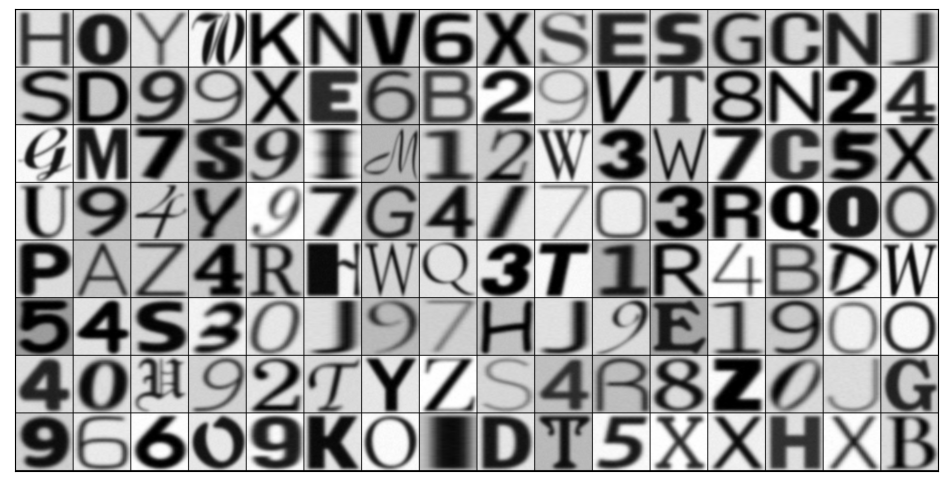

In [188]:
show_batch(train_dl)

In [189]:
#Basic model
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
)

In [190]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 128, 128])
out.shape: torch.Size([128, 8, 64, 64])


In [191]:
#Modeling and training 

In [192]:
def accuracy(outputs,actuals):
    _,preds = torch.max(outputs,dim=1)
    acc = torch.tensor(torch.sum(preds==actuals).item()/len(preds))
    return acc
class ImageClassification(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images,labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs,labels)
        acc = accuracy(outputs,labels)
        return {"val loss":loss.detach(),"val acc":acc}
    def validation_epoch_end(self,outputs):
        batch_loss = [x["val loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val loss":epoch_loss.item(),"val acc":epoch_acc.item()}
    def epoch_end(self,epoch_num,results):
        print("Epoch[{}] -> TRAIN LOSS : {:.4f} | VALIDATION LOSS : {:.4f} | VALIDATION ACC : {:.4f}"\
              .format(epoch_num,results["train loss"],results["val loss"],results["val acc"]))
    def evaluate(self,val_dl):
        outputs = [self.validation_step(batch) for batch in val_dl]
        return self.validation_epoch_end(outputs)

In [193]:
class NetworkArchitecture(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # 64 x 64 x 64 
        
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # 128 x 32 x 32  
        
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # 256 x 16 x 16
        
        nn.Flatten(),
        nn.Linear(256*16*16,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,36))
    def forward(self,xb):
        return self.network(xb)      

In [194]:
model = NetworkArchitecture()
model

NetworkArchitecture(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [195]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [196]:
device = get_default_device()
device

device(type='cuda')

In [197]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

NetworkArchitecture(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [198]:
def fit(epoch_num,lr,model,train_dl,val_dl,optim_func):
    optimizer = optim_func(model.parameters(),lr)
    history = []
    for epoch in range(epoch_num):
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        results = model.evaluate(val_dl)
        results["train loss"] = torch.stack(train_losses).mean()
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [199]:
model = to_device(NetworkArchitecture(), device)

In [200]:
model.evaluate(val_dl)

{'val loss': 3.5831806659698486, 'val acc': 0.02714843675494194}

In [201]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001

In [202]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch[0] -> TRAIN LOSS : 0.9738 | VALIDATION LOSS : 0.2907 | VALIDATION ACC : 0.9207
Epoch[1] -> TRAIN LOSS : 0.2060 | VALIDATION LOSS : 0.2268 | VALIDATION ACC : 0.9293
Epoch[2] -> TRAIN LOSS : 0.1435 | VALIDATION LOSS : 0.1751 | VALIDATION ACC : 0.9439
Epoch[3] -> TRAIN LOSS : 0.1236 | VALIDATION LOSS : 0.2160 | VALIDATION ACC : 0.9352
Epoch[4] -> TRAIN LOSS : 0.0954 | VALIDATION LOSS : 0.2089 | VALIDATION ACC : 0.9426
Epoch[5] -> TRAIN LOSS : 0.0701 | VALIDATION LOSS : 0.1993 | VALIDATION ACC : 0.9426
Epoch[6] -> TRAIN LOSS : 0.0655 | VALIDATION LOSS : 0.2002 | VALIDATION ACC : 0.9490
Epoch[7] -> TRAIN LOSS : 0.0532 | VALIDATION LOSS : 0.1982 | VALIDATION ACC : 0.9576
Epoch[8] -> TRAIN LOSS : 0.0496 | VALIDATION LOSS : 0.1688 | VALIDATION ACC : 0.9563
Epoch[9] -> TRAIN LOSS : 0.0456 | VALIDATION LOSS : 0.3036 | VALIDATION ACC : 0.9400
Epoch[10] -> TRAIN LOSS : 0.0511 | VALIDATION LOSS : 0.1865 | VALIDATION ACC : 0.9602
Epoch[11] -> TRAIN LOSS : 0.0340 | VALIDATION LOSS : 0.2243 | VA

In [208]:
Epoch[0] -> TRAIN LOSS : 0.9738 | VALIDATION LOSS : 0.2907 | VALIDATION ACC : 0.9207
Epoch[1] -> TRAIN LOSS : 0.2060 | VALIDATION LOSS : 0.2268 | VALIDATION ACC : 0.9293
Epoch[2] -> TRAIN LOSS : 0.1435 | VALIDATION LOSS : 0.1751 | VALIDATION ACC : 0.9439
Epoch[3] -> TRAIN LOSS : 0.1236 | VALIDATION LOSS : 0.2160 | VALIDATION ACC : 0.9352
Epoch[4] -> TRAIN LOSS : 0.0954 | VALIDATION LOSS : 0.2089 | VALIDATION ACC : 0.9426
Epoch[5] -> TRAIN LOSS : 0.0701 | VALIDATION LOSS : 0.1993 | VALIDATION ACC : 0.9426
Epoch[6] -> TRAIN LOSS : 0.0655 | VALIDATION LOSS : 0.2002 | VALIDATION ACC : 0.9490
Epoch[7] -> TRAIN LOSS : 0.0532 | VALIDATION LOSS : 0.1982 | VALIDATION ACC : 0.9576
Epoch[8] -> TRAIN LOSS : 0.0496 | VALIDATION LOSS : 0.1688 | VALIDATION ACC : 0.9563
Epoch[9] -> TRAIN LOSS : 0.0456 | VALIDATION LOSS : 0.3036 | VALIDATION ACC : 0.9400
Epoch[10] -> TRAIN LOSS : 0.0511 | VALIDATION LOSS : 0.1865 | VALIDATION ACC : 0.9602
Epoch[11] -> TRAIN LOSS : 0.0340 | VALIDATION LOSS : 0.2243 | VALIDATION ACC : 0.9523
Epoch[12] -> TRAIN LOSS : 0.0352 | VALIDATION LOSS : 0.2174 | VALIDATION ACC : 0.9590
Epoch[13] -> TRAIN LOSS : 0.0352 | VALIDATION LOSS : 0.3066 | VALIDATION ACC : 0.9451
Epoch[14] -> TRAIN LOSS : 0.0392 | VALIDATION LOSS : 0.2169 | VALIDATION ACC : 0.9576
Epoch[15] -> TRAIN LOSS : 0.0345 | VALIDATION LOSS : 0.2098 | VALIDATION ACC : 0.9578
Epoch[16] -> TRAIN LOSS : 0.0482 | VALIDATION LOSS : 0.1879 | VALIDATION ACC : 0.9541
Epoch[17] -> TRAIN LOSS : 0.0379 | VALIDATION LOSS : 0.2041 | VALIDATION ACC : 0.9602
Epoch[18] -> TRAIN LOSS : 0.0323 | VALIDATION LOSS : 0.1821 | VALIDATION ACC : 0.9598
Epoch[19] -> TRAIN LOSS : 0.0300 | VALIDATION LOSS : 0.2107 | VALIDATION ACC : 0.9602
Epoch[20] -> TRAIN LOSS : 0.0336 | VALIDATION LOSS : 0.1802 | VALIDATION ACC : 0.9576
Epoch[21] -> TRAIN LOSS : 0.0301 | VALIDATION LOSS : 0.1987 | VALIDATION ACC : 0.9617
Epoch[22] -> TRAIN LOSS : 0.0266 | VALIDATION LOSS : 0.2235 | VALIDATION ACC : 0.9516
Epoch[23] -> TRAIN LOSS : 0.0327 | VALIDATION LOSS : 0.2591 | VALIDATION ACC : 0.9455
Epoch[24] -> TRAIN LOSS : 0.0425 | VALIDATION LOSS : 0.2747 | VALIDATION ACC : 0.9543
Epoch[25] -> TRAIN LOSS : 0.0476 | VALIDATION LOSS : 0.2372 | VALIDATION ACC : 0.9568
Epoch[26] -> TRAIN LOSS : 0.0319 | VALIDATION LOSS : 0.2151 | VALIDATION ACC : 0.9633
Epoch[27] -> TRAIN LOSS : 0.0233 | VALIDATION LOSS : 0.1703 | VALIDATION ACC : 0.9633
Epoch[28] -> TRAIN LOSS : 0.0227 | VALIDATION LOSS : 0.1778 | VALIDATION ACC : 0.9646
Epoch[29] -> TRAIN LOSS : 0.0212 | VALIDATION LOSS : 0.1797 | VALIDATION ACC : 0.9637
Epoch[30] -> TRAIN LOSS : 0.0209 | VALIDATION LOSS : 0.2148 | VALIDATION ACC : 0.9625
Epoch[31] -> TRAIN LOSS : 0.0239 | VALIDATION LOSS : 0.2195 | VALIDATION ACC : 0.9557
Epoch[32] -> TRAIN LOSS : 0.0228 | VALIDATION LOSS : 0.2121 | VALIDATION ACC : 0.9617
Epoch[33] -> TRAIN LOSS : 0.0359 | VALIDATION LOSS : 0.2124 | VALIDATION ACC : 0.9531
Epoch[34] -> TRAIN LOSS : 0.0331 | VALIDATION LOSS : 0.1786 | VALIDATION ACC : 0.9605
Epoch[35] -> TRAIN LOSS : 0.0355 | VALIDATION LOSS : 0.1718 | VALIDATION ACC : 0.9621
Epoch[36] -> TRAIN LOSS : 0.0303 | VALIDATION LOSS : 0.2835 | VALIDATION ACC : 0.9506
Epoch[37] -> TRAIN LOSS : 0.0316 | VALIDATION LOSS : 0.1861 | VALIDATION ACC : 0.9598
Epoch[38] -> TRAIN LOSS : 0.0205 | VALIDATION LOSS : 0.2230 | VALIDATION ACC : 0.9564
Epoch[39] -> TRAIN LOSS : 0.0196 | VALIDATION LOSS : 0.2247 | VALIDATION ACC : 0.9621
Epoch[40] -> TRAIN LOSS : 0.0214 | VALIDATION LOSS : 0.2257 | VALIDATION ACC : 0.9582
Epoch[41] -> TRAIN LOSS : 0.0197 | VALIDATION LOSS : 0.2088 | VALIDATION ACC : 0.9650
Epoch[42] -> TRAIN LOSS : 0.0174 | VALIDATION LOSS : 0.1889 | VALIDATION ACC : 0.9631
Epoch[43] -> TRAIN LOSS : 0.0170 | VALIDATION LOSS : 0.3024 | VALIDATION ACC : 0.9590
Epoch[44] -> TRAIN LOSS : 0.0177 | VALIDATION LOSS : 0.2268 | VALIDATION ACC : 0.9633
Epoch[45] -> TRAIN LOSS : 0.0180 | VALIDATION LOSS : 0.2251 | VALIDATION ACC : 0.9609
Epoch[46] -> TRAIN LOSS : 0.0285 | VALIDATION LOSS : 0.2125 | VALIDATION ACC : 0.9576
Epoch[47] -> TRAIN LOSS : 0.0239 | VALIDATION LOSS : 0.2319 | VALIDATION ACC : 0.9605
Epoch[48] -> TRAIN LOSS : 0.0281 | VALIDATION LOSS : 0.2646 | VALIDATION ACC : 0.9570
Epoch[49] -> TRAIN LOSS : 0.0261 | VALIDATION LOSS : 0.2852 | VALIDATION ACC : 0.9578

In [204]:
def plot_accuracies(history):
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

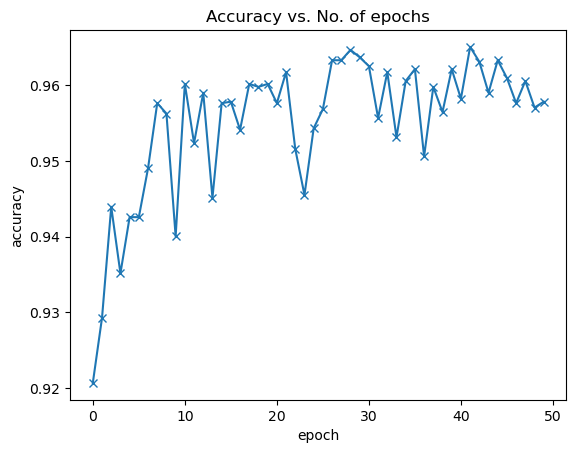

In [205]:
plot_accuracies(history)

In [206]:
def plot_losses(history):
    train_losses = [x.get('train loss').detach().cpu().numpy() for x in history]
    val_losses = [x['val loss'].detach().cpu().numpy() if isinstance(x['val loss'], torch.Tensor) else x['val loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

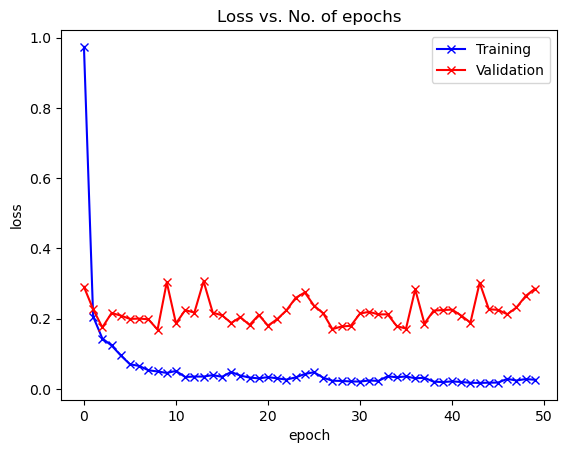

In [207]:
plot_losses(history)

In [209]:
def predict_image(img,model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb,dim=1)
    return preds.item()

Enter a number :  500


Label: 17 , Predicted: 17


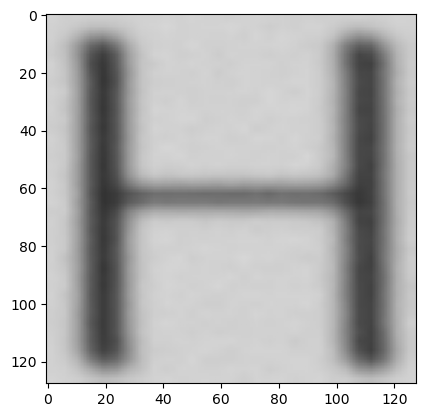

In [216]:
n = int(input("Enter a number : "))
img, label = test_data[n]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data[n][1], ', Predicted:', predict_image(img, model))

In [219]:
test_loader = DeviceDataLoader(DataLoader(test_data, 128*2), device)
result = model.evaluate(test_loader)
result

{'val loss': 0.0265192911028862, 'val acc': 0.9912109375}

In [220]:
torch.save(model.state_dict(), 'ocr.pth')